# First Blocks

In [ ]:

import open3d as o3d
import numpy as np

# Assuming 'blocks' is available and each block has XYZ and potentially RGB information
def visualize_all_blocks(blocks):
    for i, block in enumerate(blocks):
        print(f"Visualizing block {i + 1}/{len(blocks)}")
        visualize_block(block)

def visualize_block(block):
    # Create Open3D PointCloud object
    point_cloud = o3d.geometry.PointCloud()

    # Extract XYZ coordinates
    xyz = block[:, :3]

    # Set points for the point cloud
    point_cloud.points = o3d.utility.Vector3dVector(xyz)

    # Check if RGB information is available
    if block.shape[1] >= 6:
        rgb = block[:, 3:6] / 255.0  # Assuming RGB values are between 0-255, normalize to 0-1
        point_cloud.colors = o3d.utility.Vector3dVector(rgb)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([point_cloud])

# Visualize all blocks of points
visualize_all_blocks(blocks)


# First h5 format

In [ ]:
import os
import laspy
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
import h5py
from sklearn.neighbors import NearestNeighbors

class PointCloudLoader:
    def __init__(self, file_path, block_size=1024, overlap_ratio=0.1, neighbors_k=10):
        """
        Initializes the PointCloudLoader with the provided file path and parameters for block creation.
        
        :param file_path: Path to the point cloud file (e.g., .las).
        :param block_size: Number of points in each block.
        :param overlap_ratio: Ratio of overlap between consecutive blocks.
        :param neighbors_k: Number of neighbors to consider for each point.
        """
        self.file_path = file_path
        self.point_cloud = None
        self.block_size = block_size
        self.overlap_ratio = overlap_ratio
        self.neighbors_k = neighbors_k

    def load_point_cloud(self):
        """
        Loads the point cloud data from the specified file path.
        
        :return: Loaded point cloud as a numpy array.
        """
        file_extension = os.path.splitext(self.file_path)[-1].lower()

        if file_extension == ".las":
            self.point_cloud = self._load_las()
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")

        return self.point_cloud

    def _load_las(self):
        """
        Loads point cloud data from a LAS file, including intensity, RGB, and classification attributes.
        
        :return: Loaded point cloud as a numpy array.
        """
        with laspy.open(self.file_path) as las_file:
            las = las_file.read()
            points = np.vstack((las.x, las.y, las.z)).transpose()

            # Adding additional attributes if they exist
            if hasattr(las, 'intensity'):
                intensity = las.intensity[:, np.newaxis]
                points = np.hstack((points, intensity))

            if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
                rgb = np.vstack((las.red, las.green, las.blue)).transpose() / 65535.0
                points = np.hstack((points, rgb))

            if hasattr(las, 'classification_trees'):
                classification = las.classification_trees[:, np.newaxis]
                points = np.hstack((points, classification))

        return points

    def create_blocks_with_overlap(self):
        """
        Divides the point cloud into overlapping blocks of specified size and overlap ratio.
        
        :return: Blocks of points and corresponding labels.
        """
        points = self.point_cloud[:, :3]
        intensity = self.point_cloud[:, 3] if self.point_cloud.shape[1] > 3 else None
        rgb = self.point_cloud[:, 4:7] if self.point_cloud.shape[1] > 6 else None
        labels = self.point_cloud[:, -1]  if self.point_cloud.shape[1] > 7 else None
        print(labels)
        
        stride = int(self.block_size * (1 - self.overlap_ratio))
        blocks = []
        block_labels = []
        block_intensity = []
        block_rgb = []

        num_points = len(points)
        for start in range(0, num_points, stride):
            end = start + self.block_size
            block_points = points[start:end]
            if intensity is not None:
                block_intensity_points = intensity[start:end]
            if rgb is not None:
                block_rgb_points = rgb[start:end]
            if labels is not None:
                block_labels_points = labels[start:end]

            if len(block_points) == self.block_size:  # Only include full blocks
                blocks.append(block_points)
                if intensity is not None:
                    block_intensity.append(block_intensity_points)
                if rgb is not None:
                    block_rgb.append(block_rgb_points)
                if labels is not None:
                    block_labels.append(block_labels_points)

        return np.array(blocks), np.array(block_labels), np.array(block_intensity), np.array(block_rgb)

    def calculate_neighbors(self, blocks):
        """
        Calculates nearest neighbors for each point in each block.
        
        :param blocks: Array of point blocks.
        :return: Neighbor indices for each block.
        """
        neighbors_info = []

        for block in blocks:
            nbrs = NearestNeighbors(n_neighbors=self.neighbors_k).fit(block)
            _, indices = nbrs.kneighbors(block)
            neighbors_info.append(indices)

        return np.array(neighbors_info)

    def save_to_hdf5(self, hdf5_path, blocks, block_labels, block_intensity, block_rgb, neighbors_info):
        """
        Saves blocks, labels, intensity, RGB, and neighbor information to an HDF5 file.
        
        :param hdf5_path: Path to save the HDF5 file.
        :param blocks: Array of blocks with point data.
        :param block_labels: Labels for points in each block.
        :param block_intensity: Intensity values for points in each block.
        :param block_rgb: RGB values for points in each block.
        :param neighbors_info: Neighbor indices for each block.
        """
        with h5py.File(hdf5_path, "w") as f:
            f.create_dataset("blocks", data=blocks)
            f.create_dataset("labels", data=block_labels)
            f.create_dataset("intensity", data=block_intensity)
            f.create_dataset("rgb", data=block_rgb)
            f.create_dataset("neighbors", data=neighbors_info)

    def process_and_save(self, hdf5_path):
        """
        Processes the point cloud into blocks, calculates neighbors, and saves to HDF5.
        
        :param hdf5_path: Path to save the HDF5 file.
        """
        blocks, block_labels, block_intensity, block_rgb = self.create_blocks_with_overlap()
        neighbors_info = self.calculate_neighbors(blocks)
        self.save_to_hdf5(hdf5_path, blocks, block_labels, block_intensity, block_rgb, neighbors_info)

# Example usage
if __name__ == "__main__":
    loader = PointCloudLoader(r"C:\Users\lukas\Desktop\stromymale.las", block_size=1024, overlap_ratio=0.0, neighbors_k=10)
    points = loader.load_point_cloud()
    print(points)

    # Process and save to HDF5
    hdf5_path = r"C:\Users\lukas\Desktop\pointcloud_data.h5"
    loader.process_and_save(hdf5_path)


# Info about cloud

In [77]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points }")

Centroid: [14.87639286 -6.08269449  5.71710509]
Dimensions: [147.519  98.631  33.795]
total_points: 2885171


# Matplotlib voxel

Centroid: [14.87639286 -6.08269449  5.71710509]
Dimensions: [147.519  98.631  33.795]
total_points: 2885171
Number of unique voxels: 2379


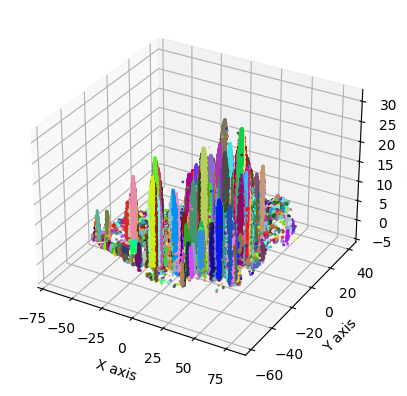

In [26]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud_big.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z)+1  # Maximum height of the point cloud

# Determine voxel indices
x_indices = np.floor((x - np.min(x)) / voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Plotting the point cloud with different colors for each voxel
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assign a random color to each unique voxel
colors = np.random.rand(len(unique_voxels), 3)

# Plot each point with the color of its voxel
for i, voxel in enumerate(unique_voxels):
    mask = (voxel_indices == voxel).all(axis=1)
    ax.scatter(x[mask], y[mask], z[mask], color=colors[i], s=1)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

# Graphic voxels

In [78]:
import laspy
import numpy as np
import open3d as o3d

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

total_points = len(las.x)
# Calculate the centroid
centroid = np.array([np.mean(x), np.mean(y), np.mean(z)])

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z) + 1  # Maximum height of the point cloud

# Determine voxel indices
x_indices = np.floor((x - np.min(x)) / voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Create an Open3D point cloud
pcd = o3d.geometry.PointCloud()
points = np.vstack((x, y, z)).T
pcd.points = o3d.utility.Vector3dVector(points)

# Assign colors to each voxel
colors = np.random.rand(len(unique_voxels), 3)
colors_pointcloud = np.zeros((total_points, 3))

for i, voxel in enumerate(unique_voxels):
    mask = (voxel_indices == voxel).all(axis=1)
    colors_pointcloud[mask] = colors[i]

pcd.colors = o3d.utility.Vector3dVector(colors_pointcloud)

# Visualize the point cloud with Open3D
o3d.visualization.draw_geometries([pcd])


Centroid: [-26.62752109 -11.24297995   7.02195917]
Dimensions: [ 8.5725973  7.7568484 19.1077004]
total_points: 535079
Number of unique voxels: 18


# Fahrest point sampling

In [ ]:
import laspy
import numpy as np

# Load the LAS file
las = laspy.read(r"C:\Users\lukas\Desktop\pointcloud.las")

# Extract x, y, z coordinates
x = las.x
y = las.y
z = las.z

# Combine coordinates into a single array
points = np.vstack((x, y, z)).T

total_points = len(points)
# Calculate the centroid
centroid = np.mean(points, axis=0)

# Calculate the dimensions (range in each axis)
dimensions = np.array([np.max(x) - np.min(x), np.max(y) - np.min(y), np.max(z) - np.min(z)])

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(z) - np.min(z) +1  # Maximum height of the point cloud

# Define overlap ratio (e.g., 0.5 for 50% overlap)
overlap_ratio = float(input("Enter overlap ratio (0 to 1): "))

# Adjust voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - overlap_ratio)

# Determine voxel indices with overlap
x_indices = np.floor((x - np.min(x)) / adjusted_voxel_size_x).astype(int)
y_indices = np.floor((y - np.min(y)) / adjusted_voxel_size_y).astype(int)
z_indices = np.floor((z - np.min(z)) / adjusted_voxel_size_z).astype(int)

# Combine the indices to create unique voxel identifiers
voxel_indices = np.vstack((x_indices, y_indices, z_indices)).T

# Get unique voxels and their counts
unique_voxels, counts = np.unique(voxel_indices, axis=0, return_counts=True)

print(f"Number of unique voxels: {len(unique_voxels)}")

# Divide each voxel into blocks with 1024 points (input to PointNet++) with overlap using Farthest Point Sampling
block_size = 1024
block_overlap_ratio = float(input("Enter block overlap ratio (0 to 1): "))
blocks = []

def farthest_point_sampling(points, n_samples):
    sampled_indices = [np.random.randint(len(points))]
    distances = np.full(len(points), np.inf)
    
    for _ in range(1, n_samples):
        last_sampled = points[sampled_indices[-1]].reshape(1, -1)
        dist = np.linalg.norm(points - last_sampled, axis=1)
        distances = np.minimum(distances, dist)
        sampled_indices.append(np.argmax(distances))
    
    return np.array(sampled_indices)

for voxel in unique_voxels:
    # Extract points in the current voxel
    mask = (voxel_indices == voxel).all(axis=1)
    voxel_points = points[mask]
    print(f"voxel {voxel_points} s {len(voxel_points)}")
    
    if len(voxel_points) < block_size:
        continue
    
    # Use Farthest Point Sampling to create blocks with overlap
    sampled_indices = set()
    
    while len(sampled_indices) < len(voxel_points):
        # Select a block using Farthest Point Sampling
        fps_indices = farthest_point_sampling(voxel_points, block_size)
        sampled_indices.update(fps_indices)
        blocks.append(voxel_points[fps_indices])
        # print(blocks)

print(f"Total number of blocks created: {len(blocks)}")


# Repaired overlaps

In [ ]:
import laspy
import numpy as np

# Load the LAS file efficiently
with laspy.open(r"C:\Users\lukas\Desktop\pointcloud.las") as las_file:
    las = las_file.read()
    points = np.vstack((las.x, las.y, las.z)).T

# Calculate the total number of points
total_points = len(points)

# Calculate the centroid
centroid = np.mean(points, axis=0)

# Calculate the dimensions (range in each axis)
dimensions = np.ptp(points, axis=0)

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = float(input("Enter voxel size for z-axis: "))

# Define voxel overlap ratio (e.g., 0.5 for 50% overlap)
voxel_overlap_ratio = float(input("Enter voxel overlap ratio (0 to 1): "))

# Generate voxel bounds and indices with overlap
x_min, y_min, z_min = np.min(points, axis=0)
x_max, y_max, z_max = np.max(points, axis=0)

# Calculate the adjusted voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - voxel_overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - voxel_overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - voxel_overlap_ratio)

# Generate overlapping voxel indices
x_indices = []
y_indices = []
z_indices = []
for i in range(int(np.ceil((x_max - x_min) / adjusted_voxel_size_x))):
    x_indices.append(x_min + i * adjusted_voxel_size_x)
for i in range(int(np.ceil((y_max - y_min) / adjusted_voxel_size_y))):
    y_indices.append(y_min + i * adjusted_voxel_size_y)
for i in range(int(np.ceil((z_max - z_min) / adjusted_voxel_size_z))):
    z_indices.append(z_min + i * adjusted_voxel_size_z)

voxel_indices = []
for x in x_indices:
    for y in y_indices:
        for z in z_indices:
            mask = (points[:, 0] >= x) & (points[:, 0] < x + voxel_size_x) & \
                   (points[:, 1] >= y) & (points[:, 1] < y + voxel_size_y) & \
                   (points[:, 2] >= z) & (points[:, 2] < z + voxel_size_z)
            voxel_points = points[mask]
            if len(voxel_points) > 0:
                voxel_indices.append((x, y, z, len(voxel_points)))

# Store points for each voxel and identify common points
voxel_dict = {}
for x, y, z, count in voxel_indices:
    key = (x, y, z)
    mask = (points[:, 0] >= x) & (points[:, 0] < x + voxel_size_x) & \
           (points[:, 1] >= y) & (points[:, 1] < y + voxel_size_y) & \
           (points[:, 2] >= z) & (points[:, 2] < z + voxel_size_z)
    voxel_points = points[mask]
    voxel_dict[key] = set(map(tuple, voxel_points))

# Check for common points between voxels
for voxel_a_key in voxel_dict:
    for voxel_b_key in voxel_dict:
        if voxel_a_key >= voxel_b_key:
            continue
        common = voxel_dict[voxel_a_key].intersection(voxel_dict[voxel_b_key])
        if common:
            print(f"Voxel {voxel_a_key} and Voxel {voxel_b_key} have {len(common)} common points.")

# Divide each voxel into blocks with 1024 points (input to PointNet++) with variable block overlap
block_size = 1024
block_overlap_ratio = float(input("Enter block overlap ratio (0 to 1): "))
blocks = []

for voxel_key in voxel_dict:
    voxel_points = np.array(list(voxel_dict[voxel_key]))
    
    print(f"Voxel {voxel_key}: Number of points in voxel: {len(voxel_points)}")
    
    if len(voxel_points) < block_size:
        continue
    
    # Create blocks with variable overlap
    overlap_points = int(block_size * block_overlap_ratio)
    start_idx = 0
    while start_idx + block_size <= len(voxel_points):
        block = voxel_points[start_idx:start_idx + block_size]
        blocks.append(block)
        start_idx += block_size - overlap_points  # Move forward by block size minus overlap to create variable overlap
    
    print(f"Voxel {voxel_key}: Number of blocks created: {(len(blocks) - start_idx) // (block_size - overlap_points)}")

print(f"Total number of blocks created: {len(blocks)}")

# Only voxel overlap

In [87]:
import laspy
import numpy as np

# Load the LAS file efficiently
with laspy.open(r"C:\Users\lukas\Desktop\pointcloud.las") as las_file:
    las = las_file.read()
    points = np.vstack((las.x, las.y, las.z)).T

# Calculate the total number of points
total_points = len(points)

# Calculate the centroid
centroid = np.mean(points, axis=0)

# Calculate the dimensions (range in each axis)
dimensions = np.ptp(points, axis=0)

print(f"Centroid: {centroid}")
print(f"Dimensions: {dimensions}")
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(points[:, 2]) - np.min(points[:, 2]) + 1  # Maximum height of the point cloud

# Define voxel overlap ratio (e.g., 0.5 for 50% overlap)
voxel_overlap_ratio = float(input("Enter voxel overlap ratio (0 to 1): "))

# Generate voxel bounds and indices with overlap
x_min, y_min, z_min = np.min(points, axis=0)
x_max, y_max, z_max = np.max(points, axis=0)

# Calculate the adjusted voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - voxel_overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - voxel_overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - voxel_overlap_ratio)

# Generate overlapping voxel indices
x_indices = []
y_indices = []
z_indices = []
for i in range(int(np.ceil((x_max - x_min) / adjusted_voxel_size_x))):
    x_indices.append(x_min + i * adjusted_voxel_size_x)
for i in range(int(np.ceil((y_max - y_min) / adjusted_voxel_size_y))):
    y_indices.append(y_min + i * adjusted_voxel_size_y)
for i in range(int(np.ceil((z_max - z_min) / adjusted_voxel_size_z))):
    z_indices.append(z_min + i * adjusted_voxel_size_z)

voxel_indices = []
for x in x_indices:
    for y in y_indices:
        for z in z_indices:
            mask = (points[:, 0] >= x) & (points[:, 0] < x + voxel_size_x) & \
                   (points[:, 1] >= y) & (points[:, 1] < y + voxel_size_y) & \
                   (points[:, 2] >= z) & (points[:, 2] < z + voxel_size_z)
            voxel_points = points[mask]
            if len(voxel_points) > 0:
                voxel_indices.append((x, y, z, len(voxel_points)))

# Store points for each voxel
voxel_dict = {}
for x, y, z, count in voxel_indices:
    key = (x, y, z)
    mask = (points[:, 0] >= x) & (points[:, 0] < x + voxel_size_x) & \
           (points[:, 1] >= y) & (points[:, 1] < y + voxel_size_y) & \
           (points[:, 2] >= z) & (points[:, 2] < z + voxel_size_z)
    voxel_points = points[mask]
    voxel_dict[key] = set(map(tuple, voxel_points))

# Divide each voxel into blocks with 1024 points (input to PointNet++) without overlap
block_size = 1024
blocks = []

for voxel_key in voxel_dict:
    voxel_points = np.array(list(voxel_dict[voxel_key]))
    
    print(f"Voxel {voxel_key}: Number of points in voxel: {len(voxel_points)}")
    
    if len(voxel_points) < block_size:
        continue
    
    # Create blocks without overlap
    start_idx = 0
    voxel_block_count = 0
    while start_idx + block_size <= len(voxel_points):
        block = voxel_points[start_idx:start_idx + block_size]
        blocks.append(block)
        voxel_block_count += 1
        start_idx += block_size  # Move forward by block size to create non-overlapping blocks
    
    print(f"Voxel {voxel_key}: Number of blocks created: {voxel_block_count}")

print(f"Total number of blocks created: {len(blocks)}")


Centroid: [-26.62752109 -11.24297995   7.02195917]
Dimensions: [ 8.5725973  7.7568484 19.1077004]
total_points: 535079


KeyboardInterrupt: Interrupted by user

# Saving to h5

In [85]:
import laspy
import numpy as np
import h5py

# Load the LAS file efficiently
with laspy.open(r"C:\Users\lukas\Desktop\pointcloud_big.las") as las_file:
    las = las_file.read()
    points = np.vstack((las.x, las.y, las.z)).T

    # Adding additional attributes if they exist
    if hasattr(las, 'intensity'):
        intensity = las.intensity[:, np.newaxis]
        points = np.hstack((points, intensity))

    if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
        rgb = np.vstack((las.red, las.green, las.blue)).T / 65535.0  # Normalize to [0, 1]
        points = np.hstack((points, rgb))

    if hasattr(las, 'classification_trees'):
        classification = las.classification_trees[:, np.newaxis]
        points = np.hstack((points, classification))
    
print(points)
# Calculate the total number of points
total_points = len(points)
print(f"total_points: {total_points}")

# Voxelization with overlap
voxel_size_x = float(input("Enter voxel size for x-axis: "))
voxel_size_y = float(input("Enter voxel size for y-axis: "))
voxel_size_z = np.max(points[:, 2]) - np.min(points[:, 2]) + 1

# Define voxel overlap ratio (e.g., 0.5 for 50% overlap)
voxel_overlap_ratio = float(input("Enter voxel overlap ratio (0 to 1): "))

# Generate voxel bounds and indices with overlap
x_min, y_min, z_min = np.min(points[:, :3], axis=0)
x_max, y_max, z_max = np.max(points[:, :3], axis=0)

# Calculate the adjusted voxel size to include overlap
adjusted_voxel_size_x = voxel_size_x * (1 - voxel_overlap_ratio)
adjusted_voxel_size_y = voxel_size_y * (1 - voxel_overlap_ratio)
adjusted_voxel_size_z = voxel_size_z * (1 - voxel_overlap_ratio)

# Generate overlapping voxel indices
x_indices = []
y_indices = []
z_indices = []
for i in range(int(np.ceil((x_max - x_min) / adjusted_voxel_size_x))):
    x_indices.append(x_min + i * adjusted_voxel_size_x)
for i in range(int(np.ceil((y_max - y_min) / adjusted_voxel_size_y))):
    y_indices.append(y_min + i * adjusted_voxel_size_y)
for i in range(int(np.ceil((z_max - z_min) / adjusted_voxel_size_z))):
    z_indices.append(z_min + i * adjusted_voxel_size_z)

voxel_indices = []
for x in x_indices:
    for y in y_indices:
        for z in z_indices:
            mask = (points[:, 0] >= x) & (points[:, 0] < x + voxel_size_x) & \
                   (points[:, 1] >= y) & (points[:, 1] < y + voxel_size_y) & \
                   (points[:, 2] >= z) & (points[:, 2] < z + voxel_size_z)
            voxel_points = points[mask]
            if len(voxel_points) > 0:
                voxel_indices.append((x, y, z, len(voxel_points)))

# Store points for each voxel
voxel_dict = {}
for x, y, z, count in voxel_indices:
    key = (x, y, z)
    mask = (points[:, 0] >= x) & (points[:, 0] < x + voxel_size_x) & \
           (points[:, 1] >= y) & (points[:, 1] < y + voxel_size_y) & \
           (points[:, 2] >= z) & (points[:, 2] < z + voxel_size_z)
    voxel_points = points[mask]
    voxel_dict[key] = voxel_points

# Divide each voxel into blocks with 1024 points (input to PointNet++) without overlap
block_size = 1024
blocks = []
block_metadata = []

for voxel_key in voxel_dict:
    voxel_points = voxel_dict[voxel_key]
    
    print(f"Voxel {voxel_key}: Number of points in voxel: {len(voxel_points)}")
    
    if len(voxel_points) < block_size:
        continue
    
    # Create blocks without overlap
    start_idx = 0
    voxel_block_count = 0
    while start_idx + block_size <= len(voxel_points):
        block = voxel_points[start_idx:start_idx + block_size]
        blocks.append(block)
        block_metadata.append({'voxel_key': voxel_key, 'block_index': voxel_block_count})
        voxel_block_count += 1
        start_idx += block_size  # Move forward by block size to create non-overlapping blocks
    
    print(f"Voxel {voxel_key}: Number of blocks created: {voxel_block_count}")

print(f"Total number of blocks created: {len(blocks)}")

# Save data to HDF5 format for PointNet++
with h5py.File(r"C:\Users\lukas\Desktop\pointcloud_blocks.h5", 'w') as h5f:
    grp = h5f.create_group('voxels')
    for voxel_key, voxel_points in voxel_dict.items():
        voxel_name = f"voxel_{voxel_key[0]}_{voxel_key[1]}_{voxel_key[2]}"
        voxel_grp = grp.create_group(voxel_name)
        voxel_grp.create_dataset('points', data=voxel_points)
        voxel_grp.attrs['voxel_key'] = voxel_key

    blocks_grp = h5f.create_group('blocks')
    for i, block in enumerate(blocks):
        block_name = f"block_{i}"
        block_grp = blocks_grp.create_group(block_name)
        block_grp.create_dataset('points', data=block)
        block_grp.attrs['voxel_key'] = block_metadata[i]['voxel_key']
        block_grp.attrs['block_index'] = block_metadata[i]['block_index']

print("Data has been saved to HDF5 format.")


[[ 6.37840369e+00 -2.28180161e+00  5.13000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 6.53240369e+00 -1.36801605e-01  5.04000000e-01  1.87610000e+04
   0.00000000e+00]
 [ 6.28440369e+00  1.23198395e-01  5.15000000e-01  2.57000000e+02
   0.00000000e+00]
 ...
 [ 5.11074037e+01 -2.30558016e+01  7.60500000e+00  7.71000000e+03
   8.30000000e+01]
 [ 4.80464037e+01 -1.62978016e+01  3.82100000e+00  3.08400000e+03
   2.55000000e+02]
 [ 4.74774037e+01 -1.68068016e+01  4.87500000e+00  5.14000000e+02
   2.55000000e+02]]
total_points: 2885171
Voxel (-68.22059631347656, -35.50680160522461, -3.387): Number of points in voxel: 2
Voxel (-68.22059631347656, -31.00680160522461, -3.387): Number of points in voxel: 193
Voxel (-68.22059631347656, -26.50680160522461, -3.387): Number of points in voxel: 79
Voxel (-68.22059631347656, -22.00680160522461, -3.387): Number of points in voxel: 386
Voxel (-68.22059631347656, -17.50680160522461, -3.387): Number of points in voxel: 80
Voxel (-68.22059631347656, -13.

# h5 struture load

In [21]:
import h5py
import numpy as np

# Open the HDF5 file in read mode
with h5py.File(r"C:\Users\lukas\Desktop\pointcloud_blocks.h5", 'r') as h5f:
    # Ensure both 'voxels' and 'blocks' groups exist
    if 'voxels' in h5f and 'blocks' in h5f:
        voxels_grp = h5f['voxels']
        blocks_grp = h5f['blocks']
        
        print("Voxel and Block Structure:")

        # Iterate over each voxel group
        for voxel_name, voxel_grp in voxels_grp.items():
            # Print voxel details
            print(f"\nVoxel: {voxel_name}")
            print(f"  Points shape: {voxel_grp['points'].shape}")
            print(f"  Voxel key: {voxel_grp.attrs['voxel_key']}")

            # Find and print blocks associated with this voxel
            print("  Blocks in this voxel:")
            for block_name, block_grp in blocks_grp.items():
                # Use np.array_equal to compare voxel keys
                if np.array_equal(block_grp.attrs['voxel_key'], voxel_grp.attrs['voxel_key']):
                    print(f"    {block_name}")
                    print(f"      Points shape: {block_grp['points'].shape}")
                    print(f"      Block index: {block_grp.attrs['block_index']}")

print("Voxel and Block information display complete.")


Voxel and Block Structure:

Voxel: voxel_-27.704090118408203_-11.375247955322266_0.10385699999999999
  Points shape: (233068, 8)
  Voxel key: [-27.70409012 -11.37524796   0.103857  ]
  Blocks in this voxel:
    block_392
      Points shape: (1024, 8)
      Block index: 0
    block_393
      Points shape: (1024, 8)
      Block index: 1
    block_394
      Points shape: (1024, 8)
      Block index: 2
    block_395
      Points shape: (1024, 8)
      Block index: 3
    block_396
      Points shape: (1024, 8)
      Block index: 4
    block_397
      Points shape: (1024, 8)
      Block index: 5
    block_398
      Points shape: (1024, 8)
      Block index: 6
    block_399
      Points shape: (1024, 8)
      Block index: 7
    block_400
      Points shape: (1024, 8)
      Block index: 8
    block_401
      Points shape: (1024, 8)
      Block index: 9
    block_402
      Points shape: (1024, 8)
      Block index: 10
    block_403
      Points shape: (1024, 8)
      Block index: 11
    block_4

In [ ]:
import h5py
import numpy as np

# Open the HDF5 file and load data for PointNet++
with h5py.File(r"C:\Users\lukas\Desktop\pointcloud_blocks.h5", 'r') as h5f:
    if 'voxels' in h5f and 'blocks' in h5f:
        voxels_grp = h5f['voxels']
        blocks_grp = h5f['blocks']

        # Collect all voxel and block points for PointNet++
        voxel_data = []
        for voxel_name, voxel_grp in voxels_grp.items():
            voxel_points = np.array(voxel_grp['points'])[:, :3]
            voxel_data.append(voxel_points)

        block_data = []
        for block_name, block_grp in blocks_grp.items():
            block_points = np.array(block_grp['points'])[:, :3]
            block_data.append(block_points)

        # Prepare data for PointNet++
        voxel_data = np.concatenate(voxel_data, axis=0) if voxel_data else np.array([])
        block_data = np.concatenate(block_data, axis=0) if block_data else np.array([])

        print("Voxel data shape for PointNet++:", voxel_data.shape)
        print("Block data shape for PointNet++:", block_data.shape)




# First model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

# Step 1: Create a Custom Dataset
class PointCloudDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        # Load the data from HDF5 file
        self.data = []
        with h5py.File(data_path, 'r') as h5f:
            blocks_grp = h5f['blocks']
            for block_name in blocks_grp:
                block_grp = blocks_grp[block_name]
                points = block_grp['points'][:]
                self.data.append(points)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        point_block = self.data[idx]  # Shape: (1024, 4) - (x, y, z, intensity)
        points = point_block[:, :4]  # XYZ + intensity
        label = point_block[0, -1]  # Assuming all points in the block have the same class label
        return points, label

# Step 2: Define the PointNet++ Model (using a basic architecture for simplicity)
class PointNetPlusPlus(nn.Module):
    def __init__(self, num_classes):
        super(PointNetPlusPlus, self).__init__()
        # Simplified PointNet++ layers for feature learning
        self.sa1 = nn.Sequential(
            nn.Conv1d(4, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 256, 1),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(2, 1)  # Input shape: (batch_size, num_points, num_features) -> (batch_size, num_features, num_points)
        x = self.sa1(x)
        x, _ = torch.max(x, 2)  # Global feature (max pooling)
        x = x.view(-1, 256)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Training Loop
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 16
    num_epochs = 50
    learning_rate = 0.00001
    num_classes = 10  # Assuming 10 different tree classes

    # Dataset and DataLoader
    dataset = PointCloudDataset(r"C:\Users\lukas\Desktop\pointcloud_blocks.h5")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model, Loss, and Optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PointNetPlusPlus(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (points, labels) in enumerate(dataloader):
            points, labels = points.to(device).float(), labels.to(device).long()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(points)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

    print("Training Finished!")



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [67]:
import h5py
import numpy as np
import os

# Directory to save the point cloud data as .txt files
output_dir = r"C:\Users\lukas\Desktop\pointnet_data"
os.makedirs(output_dir, exist_ok=True)

# Open the HDF5 file and load data for PointNet++
with h5py.File(r"C:\Users\lukas\Desktop\pointcloud_blocks.h5", 'r') as h5f:
    if 'voxels' in h5f and 'blocks' in h5f:
        voxels_grp = h5f['voxels']
        blocks_grp = h5f['blocks']

        # Save voxel data to .txt files, maintaining HDF5 structure
        for voxel_name, voxel_grp in voxels_grp.items():
            voxel_points = np.array(voxel_grp['points'])
            voxel_key = voxel_grp.attrs['voxel_key']
            output_path = os.path.join(output_dir, f"{voxel_name}.txt")
            with open(output_path, 'w') as f:
                f.write(f"# Voxel key: {voxel_key}\n")
                np.savetxt(f, voxel_points, fmt="%.6f")
            print(f"Voxel data saved to {output_path}")

        # Save block data to .txt files, maintaining HDF5 structure
        for block_name, block_grp in blocks_grp.items():
            block_points = np.array(block_grp['points'])
            voxel_key = block_grp.attrs['voxel_key']
            block_index = block_grp.attrs['block_index']
            output_path = os.path.join(output_dir, f"{block_name}.txt")
            with open(output_path, 'w') as f:
                f.write(f"# Voxel key: {voxel_key}\n")
                f.write(f"# Block index: {block_index}\n")
                np.savetxt(f, block_points, fmt="%.6f")
            print(f"Block data saved to {output_path}")

Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-13.00680160522461_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-18.00680160522461_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-23.00680160522461_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-28.00680160522461_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-3.0068016052246094_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-33.00680160522461_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-38.00680160522461_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-43.00680160522461_-3.387.txt
Voxel data saved to C:\Users\lukas\Desktop\pointnet_data\voxel_-13.220596313476562_-48.00680160


KeyboardInterrupt



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a Custom Dataset
class PointCloudDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        # Load the data from HDF5 file
        self.data = []
        self.max_label = 0
        with h5py.File(data_path, 'r') as h5f:
            blocks_grp = h5f['blocks']
            for block_name in blocks_grp:
                block_grp = blocks_grp[block_name]
                points = block_grp['points'][:]
                self.data.append(points)
                label = points[0, -1]
                if label > self.max_label:
                    self.max_label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        point_block = self.data[idx]  # Shape: (1024, 4) - (x, y, z, intensity)
        points = point_block[:, :4]  # XYZ + intensity
        label = point_block[0, -1]  # Assuming all points in the block have the same class label
        return points, label

# Step 2: Define the PointNet++ Model (using a basic architecture for simplicity)
class PointNetPlusPlus(nn.Module):
    def __init__(self, num_classes):
        super(PointNetPlusPlus, self).__init__()
        # Simplified PointNet++ layers for feature learning
        self.sa1 = nn.Sequential(
            nn.Conv1d(4, 64, 1),
            nn.ReLU(),
            nn.Conv1d(64, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 256, 1),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.transpose(2, 1)  # Input shape: (batch_size, num_points, num_features) -> (batch_size, num_features, num_points)
        x = self.sa1(x)
        x, _ = torch.max(x, 2)  # Global feature (max pooling)
        x = x.view(-1, 256)
        x = torch.relu(self.fc1)
        x = self.fc2(x)
        return x

# Step 3: Training Loop
if __name__ == "__main__":
    # Dataset and DataLoader
    dataset = PointCloudDataset(r"C:\Users\lukas\Desktop\pointcloud_blocks.h5")
    num_classes = int(dataset.max_label) + 1  # Set num_classes based on the maximum label value in the dataset

    # Hyperparameters
    batch_size = 16
    num_epochs = 50
    learning_rate = 0.00001

    # Dataset and DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model, Loss, and Optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = PointNetPlusPlus(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    loss_history = []
    accuracy_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (points, labels) in enumerate(dataloader):
            points, labels = points.to(device).float(), labels.to(device).long()
            optimizer.zero_grad()

            # Forward pass
            outputs = model(points)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = 100 * correct / total
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Plot the loss function and accuracy
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(range(1, num_epochs + 1), accuracy_history, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy over Epochs')
    plt.grid()

    plt.tight_layout()
    plt.show()

    print("Training Finished!")


TypeError: relu(): argument 'input' (position 1) must be Tensor, not Linear